# Adaption der Objektextraktion
Object Abstraction Original Script von Beat Tödtli 
https://www.kaggle.com/code/toedtlifhsg/giraffenpuzzle-objektextraktion

In [235]:
# ============================================================================
# SCHRITT 1: LADE ALLE SCRIPTS
# ============================================================================
# Dies muss zuallererst ausgeführt werden, damit alle Funktionen verfügbar sind
# Alle Vorbereitungsfunktionen sind in scripts/semesterarbeit_preparation.py ausgelagert

# ============================================================================
# IMPORTS - Alle benötigten Bibliotheken
# ============================================================================
import sys
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.measure import label, regionprops
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import shutil
import zipfile
from IPython.display import FileLink
# Füge das ÜBERGEORDNETE Verzeichnis zum Python-Pfad hinzu (muss vor dem Import sein)
# Damit funktioniert 'from scripts.xxx import ...'
current_dir = os.getcwd()
if current_dir not in sys.path:
    sys.path.insert(0, current_dir)

# Importiere die Vorbereitungsfunktionen
from scripts.semesterarbeit_preparation import setup_environment

# Führe alle Vorbereitungsschritte aus
# Dies prüft Module, lädt Scripts und Config
setup_result = setup_environment(install_missing_modules=True)

# Extrahiere Funktionen und Parameter
functions = setup_result['functions']
params = setup_result['params']

# Setze alle Parameter-Variablen für einfachen Zugriff
config = params['config']
extraction_config = params['extraction_config']
pr = params['pr']
fr = params['fr']
fc = params['fc']
vth = params['vth']
es = params['es']
ds = params['ds']
mpx = params['mpx']
saturation_threshold = params['saturation_threshold']
value_threshold = params['value_threshold']
Bilddateiendung = params['bilddateiendung']
fv = params['fv']

# Stelle alle Funktionen global zur Verfügung
choose_an_image = functions['choose_an_image']
resize_image = functions['resize_image']
fill_borders = functions['fill_borders']
create_mask_from_image = functions['create_mask_from_image']
apply_morphology = functions['apply_morphology']
extract_objects = functions['extract_objects']
filter_small_objects = functions['filter_small_objects']
print_region_sizes = functions['print_region_sizes']

# Stelle object_extraction Modul zur Verfügung
object_extraction = functions['object_extraction']
# Importiere häufig verwendete Funktionen aus object_extraction
from object_extraction import process_file, image_preprocessing, save_regionlist_to_folder, generate_mask_with_hsv_threshold, create_masked_image, create_mask, extract_regions

# Hilfsfunktion zum Anzeigen von Bildern
def show_image(image, show_colorbar=False):
    """Zeigt ein Bild an (NumPy Array oder PIL Image)"""
    if hasattr(image, 'shape'):  # NumPy Array
        im = plt.imshow(image)
    else:  # PIL Image
        im = plt.imshow(np.array(image))
    plt.axis('off')
    if show_colorbar:
        plt.colorbar(im)
    plt.show()

# Funktion zur Visualisierung von Regionen
def visualize_regions(regions):
    """
    Visualisiert die extrahierten Regionen.
    
    Args:
        regions: Liste von RegionProps-Objekten (z.B. regions1, regions2, etc.)
    """
    if len(regions) < 10:
        for ireg, reg in enumerate(regions):
            print(f"Region {ireg}: {int(reg.area):>6}")
            # Zeige jede Region als Bild (wie im Original)
            plt.figure()
            plt.imshow(reg.image_intensity)
            plt.xticks([])
            plt.yticks([])  # Wir brauchen keine x- und y-Achse
            plt.title(f"Region {ireg}: {int(reg.area)} Pixel")
        # Zeige auch bei wenigen Regionen ein Histogramm
        plt.figure()
        plt.hist([reg.area for reg in regions], bins=np.logspace(1, 6, 100))
        plt.gca().set_xscale('log')  # ev. sieht man damit etwas mehr
        plt.gca().set_yscale('log')
        plt.title("Verteilung der Region-Größen")
        plt.show()
    else:
        # for ireg,reg in enumerate(regions):
        #     print(f"{int(reg.area):<3} ",end='')
        
        plt.hist([reg.area for reg in regions], bins=np.logspace(1, 6, 100))
        plt.gca().set_xscale('log')  # ev. sieht man damit etwas mehr
        plt.gca().set_yscale('log')
        plt.show()  # Zeige das Histogramm an

# Funktion zum Filtern und Anzeigen relevanter Regionen
def show_relevant_regions(regions, min_pixels=None):
    """
    Filtert und zeigt relevante Regionen an (Regionen mit mindestens min_pixels Pixeln).
    
    Args:
        regions: Liste von RegionProps-Objekten (z.B. regions1, regions2, etc.)
        min_pixels: Mindestanzahl Pixel pro Region. Wenn None, wird mpx verwendet.
    """
    # Verwende mpx als Standard, falls min_pixels nicht angegeben
    if min_pixels is None:
        min_pixels = mpx
    
    # Filtere relevante Regionen
    relevante_regionen = [reg for reg in regions if reg.area >= min_pixels]
    
    if len(relevante_regionen) == 0:
        print(f"Keine Regionen mit >= {min_pixels} Pixeln gefunden. Zeige alle Regionen:")
        relevante_regionen = regions  # Zeige alle Regionen, wenn keine gefilterten gefunden wurden
    
    if len(relevante_regionen) < 20:
        for reg in relevante_regionen:
            plt.figure()
            plt.imshow(reg.image_intensity)
            plt.xticks([])
            plt.yticks([])  # Wir brauchen keine x- und y-Achse
        plt.show()  # Zeige alle Bilder an
    else:
        print(f"Das würde {len(relevante_regionen)} Graphiken erzeugen! Ich mache lieber nichts...")
    
    return relevante_regionen

print("\n✓ Alle Vorbereitungsschritte abgeschlossen!")


✓ Pfad hinzugefügt: d:\dev\git\privat\Studium\dsci-semesterarebeit
Python-Environment-Informationen:
  Python-Executable: d:\dev\anaconda\python.exe
  Python-Version: 3.12.7 | packaged by Anaconda, Inc. | (main, Oct  4 2024, 13:17:27) [MSC v.1929 64 bit (AMD64)]
  Python-Pfad: ['d:\\dev\\git\\privat\\Studium\\dsci-semesterarebeit', 'd:\\dev\\anaconda\\python312.zip']

✓ numpy ist installiert
✓ matplotlib ist installiert
✓ scikit-image ist installiert
✓ scikit-learn ist installiert
✓ scipy ist installiert
✓ progressbar2 ist installiert
✓ Pillow ist installiert
✓ pandas ist installiert

✓ Alle benötigten Module sind installiert!

✓ Alle Scripts wurden erfolgreich geladen!

✓ Alle Vorbereitungsschritte abgeschlossen!


In [236]:
# ============================================================================
# SCHRITT 2: ZEIGE CONFIG PARAMETER
# ============================================================================
# Die Config wurde bereits in Schritt 1 geladen
# Hier werden nur die Parameter angezeigt

import importlib
import sys

# Lade das Modul neu, falls es bereits geladen wurde
if 'scripts.semesterarebeit_object_extraktion' in sys.modules:
    importlib.reload(sys.modules['scripts.semesterarebeit_object_extraktion'])

from scripts.semesterarebeit_object_extraktion import print_extraction_parameters

# Zeige die geladenen Parameter an (übergib das Config-Objekt)
print_extraction_parameters(config)

print("\n✓ Config-Parameter angezeigt!")


Parameter für Objektextraktion:
  Auflösung: Längere Seite = 400px (proportional)
  Value Threshold: 140
  Minimum Pixel: 2000
  Erosion/Dilatation: 0/5 ( Minimale Transformation, da ursprüngliche Maske besser ist!)

✓ Config-Parameter angezeigt!


## Setup und Zugriff zu den Bilddaten

In [237]:
# Zeige Inhalt des data-Verzeichnisses
from scripts.semesterarebeit_object_extraktion import list_data

list_data()

Inhalt von 'd:\dev\git\privat\Studium\dsci-semesterarebeit\data':
  - schraubenschluessel
  - schraubenzieher
  - seidenschneider


Wenn das geklappt hat, haben Sie Zugriff auf die Daten! In der nächsten Zelle muss einfach der Pfad richtig angepasst werden. Dann sind Sie gerüstet für den Rest des Notebooks. Kopieren Sie jenen Pfad als String in die folgende Variable:

Als nächstes benötigen wir den Pfad zu `lcl_colab/1_object_extraction`. Er muss in sys.path zu finden sein. In der nächsten Zelle wird dies getestet:

Alle scrpte und Importe sind geladen. 

Laden wir ein Bild aus jedem unserer Klassen Ordner. 

Inhalt von data:
- d:\dev\git\privat\Studium\dsci-semesterarebeit\data\schraubenschluessel
- d:\dev\git\privat\Studium\dsci-semesterarebeit\data\schraubenzieher
- d:\dev\git\privat\Studium\dsci-semesterarebeit\data\seidenschneider

BEISPIELBILDER AUS JEDEM ORDNER
Gewählte Klasse: schraubenschluessel
Datei: IMG_2127.JPEG
Gewählte Klasse: schraubenzieher
Datei: IMG_1884.JPEG
Gewählte Klasse: seidenschneider
Datei: IMG_2011.JPEG


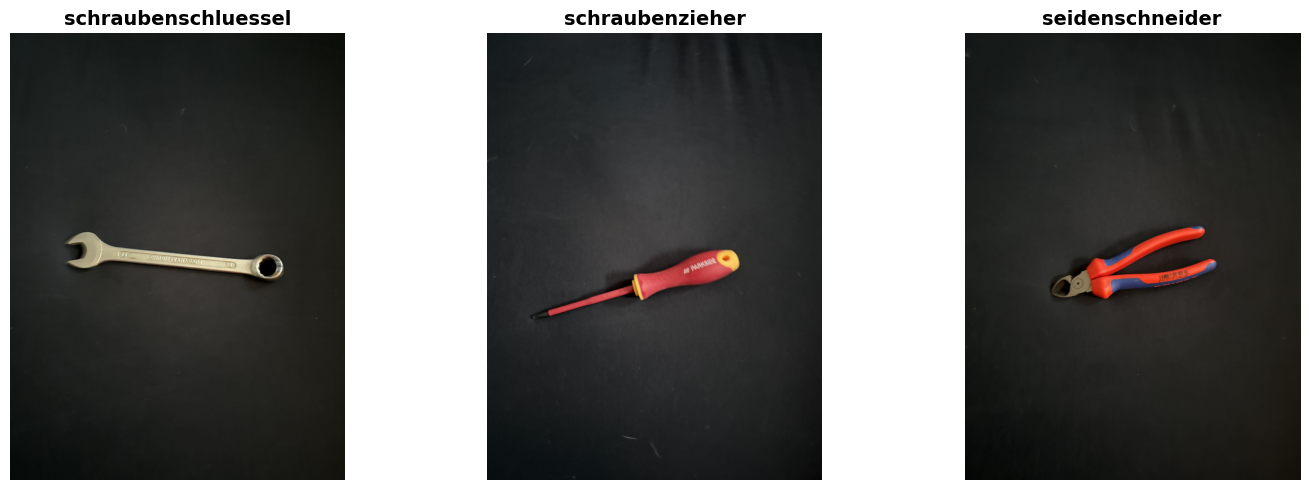


✓ 3 Beispielbilder geladen und angezeigt!


In [238]:
# Importiere die aktualisierte Funktion
from pathlib import Path
import os
import matplotlib.pyplot as plt
from scripts.schritt0_bild_laden import choose_an_image

base_path = Path(os.getcwd()) / "data"
dataset_paths = {
    "schraubenschluessel": base_path / "schraubenschluessel",
    "schraubenzieher": base_path / "schraubenzieher",
    "seidenschneider": base_path / "seidenschneider"
}

print("Inhalt von data:")
if base_path.exists():
    for p in base_path.iterdir():
        print("-", p)
else:
    print(f"Warnung: Verzeichnis {base_path} existiert nicht!")

# Lade für jeden Ordner ein Beispielbild
print("\n" + "="*70)
print("BEISPIELBILDER AUS JEDEM ORDNER")
print("="*70)

im1, klasse1 = choose_an_image(dataset_paths, klasse_name="schraubenschluessel")
im2, klasse2 = choose_an_image(dataset_paths, klasse_name="schraubenzieher")
im3, klasse3 = choose_an_image(dataset_paths, klasse_name="seidenschneider")

# Zeige alle Bilder nebeneinander
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(im1)
axes[0].set_title(klasse1, fontsize=14, fontweight='bold')
axes[0].axis('off')

axes[1].imshow(im2)
axes[1].set_title(klasse2, fontsize=14, fontweight='bold')
axes[1].axis('off')

axes[2].imshow(im3)
axes[2].set_title(klasse3, fontsize=14, fontweight='bold')
axes[2].axis('off')

plt.tight_layout()
plt.show()

print(f"\n✓ 3 Beispielbilder geladen und angezeigt!")


# Parameteranpassung für die Objektextraktion

Wir haben Zugriff auf die Bilddaten. Nun werden die Parameterwerte ausgewählt, welche die Objekte gut vom Hintergrund isolieren. Die Funktion `process_file` führt die komplette Verarbeitung durch.

Das Vorgehen besteht aus folgenden Schritten:

1. **Auflösungsreduktion**: Das Bild wird verkleinert, um die Rechenzeit zu reduzieren. Der Parameter **`pr`** gibt die maximale Seitenlänge in Pixeln an (z.B. 400px). Die Proportionen des Bildes werden dabei beibehalten.

2. **Ränder abschneiden** (optional): An den Rändern kann ein Prozentsatz der Zeilen bzw. Spalten abgeschnitten werden, um Artefakte zu beseitigen. Der Prozentsatz der Zeilen wird durch **`fr`**, jener der Spalten durch **`fc`** festgelegt. Die abgeschnittenen Bereiche werden mit dem Wert **`fv`** (value_to_fill) aufgefüllt.

3. **Hintergrundschwellwert**: Ein Schwellwert wird auf den Value-Kanal im HSV-Farbraum angewendet, um den Hintergrund vom Objekt zu trennen. Der Parameter **`vth`** (value_threshold) bestimmt den Schwellwert. Dies ergibt eine binäre Maske, welche die Vordergrundpixel (Objekt) identifiziert.

4. **Morphologische Transformation**: Kleine Artefakte auf der Maske werden durch morphologische Operationen entfernt oder verbessert. Der Parameter **`es`** (erosion_size) gibt die Größe des Erosionskerns an, **`ds`** (dilation_size) die Größe des Dilatationskerns. Erosion entfernt kleine Störungen, Dilatation füllt kleine Lücken.

5. **Objekte extrahieren**: Separate Objekte werden in der Maske identifiziert. Dazu werden verbundene Komponenten gelabelt und für jedes Objekt eine Bounding Box erstellt.

6. **Kleine Objekte filtern**: Objekte mit weniger als **`mpx`** (minimum_pixels) Pixeln werden verworfen. Dies filtert Reflexionen und andere kleine Artefakte, die kein vollständiges Objekt darstellen.

7. **Speichern**: Für jedes gefundene Objekt wird ein neues Bild gespeichert, welches nur noch das ausgeschnittene Objektelement enthält.

Wenn dies erfolgreich ist, sind die Bilder in einer geeigneten Form für das Training eines Deep-Learning-Modells.

Im Folgenden wird dieser Vorgang Schritt für Schritt für Beispielbilder durchgeführt. Die Parameter können in der Konfigurationsdatei angepasst werden.


### Schritt: Laden der Bilder

Die Bilder haben aktuell folgende Auflösungen

In [239]:
np_im = np.array(im1)
print(klasse1)
print("Shape:", np_im.shape)
print("Size:", im1.size)
print("Mode:", im1.mode)
print("")
print("------------")
print(klasse2)
print("Shape:", np_im.shape)
print("Size:", im2.size)
print("Mode:", im2.mode)
print("")
print("------------")
print(klasse3)
print("Shape:", np_im.shape)
print("Size:", im3.size)
print("Mode:", im3.mode)
print("")
print("------------")

schraubenschluessel
Shape: (2048, 1536, 3)
Size: (1536, 2048)
Mode: RGB

------------
schraubenzieher
Shape: (2048, 1536, 3)
Size: (1536, 2048)
Mode: RGB

------------
seidenschneider
Shape: (2048, 1536, 3)
Size: (1536, 2048)
Mode: RGB

------------


### Schritt 1: Auflösungsreduktion

Die Bilder können zu hoch aufgelöst sein für unsere Anwendung, wodurch sich die Rechenzeit der folgenden Operationen vervielfacht. Die Vorverarbeitungsroutine `object_extraction.py` beginnt daher damit, mit der `--preprocessing_resolution` (oder `-pr`) das Bild zu verkleinern: Ich habe mich für eine Maximale Seitenlänge von 400px entschieden. 

Ursprüngliche Bildgröße: 1536 x 2048
Längere Seite wird auf 400px gesetzt
Neue Bildgröße (proportional): 300 x 400
Skalierungsfaktor: 0.195
Ursprüngliche Bildgröße: 1536 x 2048
Längere Seite wird auf 400px gesetzt
Neue Bildgröße (proportional): 300 x 400
Skalierungsfaktor: 0.195
Ursprüngliche Bildgröße: 1536 x 2048
Längere Seite wird auf 400px gesetzt
Neue Bildgröße (proportional): 300 x 400
Skalierungsfaktor: 0.195


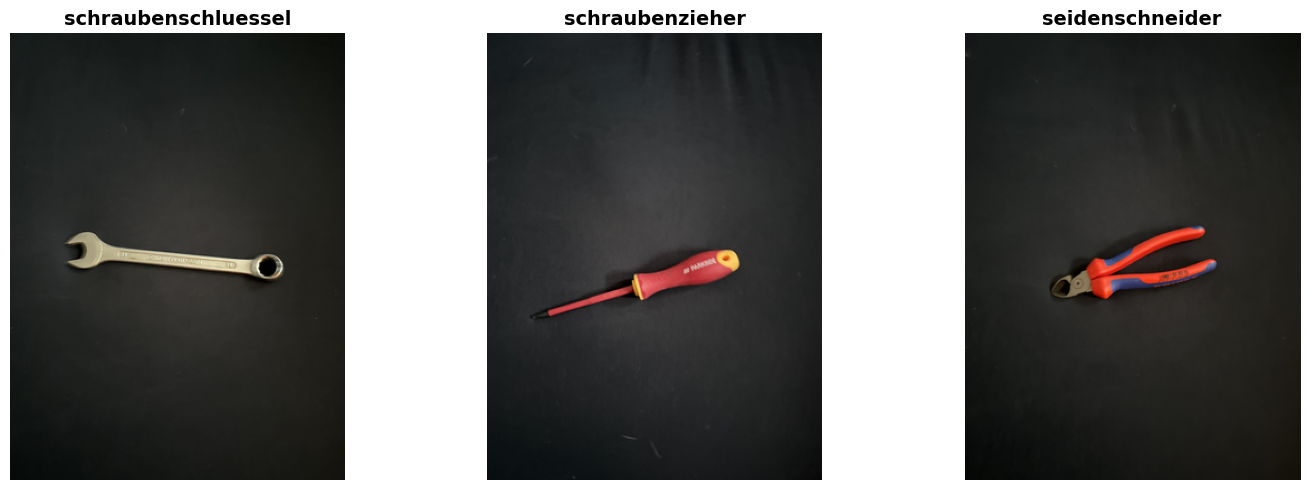

In [240]:
# Importiere die Funktion aus dem Skript
from scripts.schritt1_aufloesungsreduktion import resize_image

# Verwende die Funktion

im1_resized = resize_image(im1, pr)
im2_resized = resize_image(im2, pr)
im3_resized = resize_image(im3, pr)
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(im1_resized)
axes[0].set_title(klasse1, fontsize=14, fontweight='bold')
axes[0].axis('off')

axes[1].imshow(im2_resized)
axes[1].set_title(klasse2, fontsize=14, fontweight='bold')
axes[1].axis('off')

axes[2].imshow(im3_resized)
axes[2].set_title(klasse3, fontsize=14, fontweight='bold')
axes[2].axis('off')

plt.tight_layout()
plt.show()

Die Auflösung sollte nun Ihren Wünschen entsprechen (`NrRows`, `NrCols`, Anzahl Farbkanäle):

In [241]:
np_im = np.array(im1_resized)
print(klasse1)
print("Shape:", np_im.shape)
print("Size:", im1_resized.size)
print("Mode:", im1_resized.mode)
print("----------------------------")
print(klasse2)
print("Shape:", np_im.shape)
print("Size:", im2_resized.size)
print("Mode:", im2_resized.mode)
print("----------------------------")
print(klasse3)
print("Shape:", np_im.shape)
print("Size:", im3_resized.size)
print("Mode:", im3_resized.mode)
print("----------------------------")

schraubenschluessel
Shape: (400, 300, 3)
Size: (300, 400)
Mode: RGB
----------------------------
schraubenzieher
Shape: (400, 300, 3)
Size: (300, 400)
Mode: RGB
----------------------------
seidenschneider
Shape: (400, 300, 3)
Size: (300, 400)
Mode: RGB
----------------------------


## Schritt 2: Ränder abschneiden
Als nächstes müssen ev. die Ränder des Bildes überdeckt werden. Damit können Artefakte beseitigt werden, z.B. wenn der schwarze Hintergrund nicht bis an den Rand des Bildes reicht. `fraction_of_rows_to_remove` und `fraction_of_cols_to_remove` geben an, wieviel abgeschnitten wird. Aufgefüllt werden die Pixel mit dem Wert `value_to_fill=0` (in allen Farbkanälen). 
! Dieser Schritt war nicht nötig ich habe alle Bilder ordnungsgemäss aufgenommen.
Ich habe als beispiel ein Bild die ränder abgeschnitten verwende jedoch im_filled nicht 

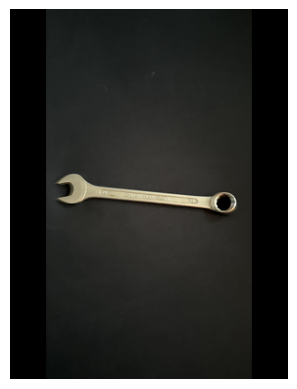

In [242]:
# Importiere die Funktion aus dem Skript
from scripts.schritt2_raender_abschneiden import fill_borders
im_filled = fill_borders(im1_resized,value_to_fill=fv,fraction_of_rows_to_remove=fr,
                         fraction_of_cols_to_remove=fc)
show_image(im_filled);

### Schritt 3: Hintergrundschwellwert bestimmen
Wählen Sie zunächst sign=+1 für Schwarzen Hintergrund oder sign=-1 für weissen Hintergrund.

Als nächstes soll ein Schwellwert im Farbraum das Objekt vom Hintergrund isolieren. Wir arbeiten im *hsv*-Raum: hue, saturation und value sind die drei Farbdimensionen, für welche jeweils ein Mindestwert (für sign=+1) bzw. Maximalwert (für sign=-1) für Vordergrundpixel festgelegt werden kann. Berechnet wird konkret: `mask = sign*im_hsv[:,:,2]<value_schwellwert*sign` (etc.).

im_filled Shape: (400, 300, 3), dtype: uint8
im_filled Shape: (400, 300, 3), dtype: uint8
im_filled Shape: (400, 300, 3), dtype: uint8


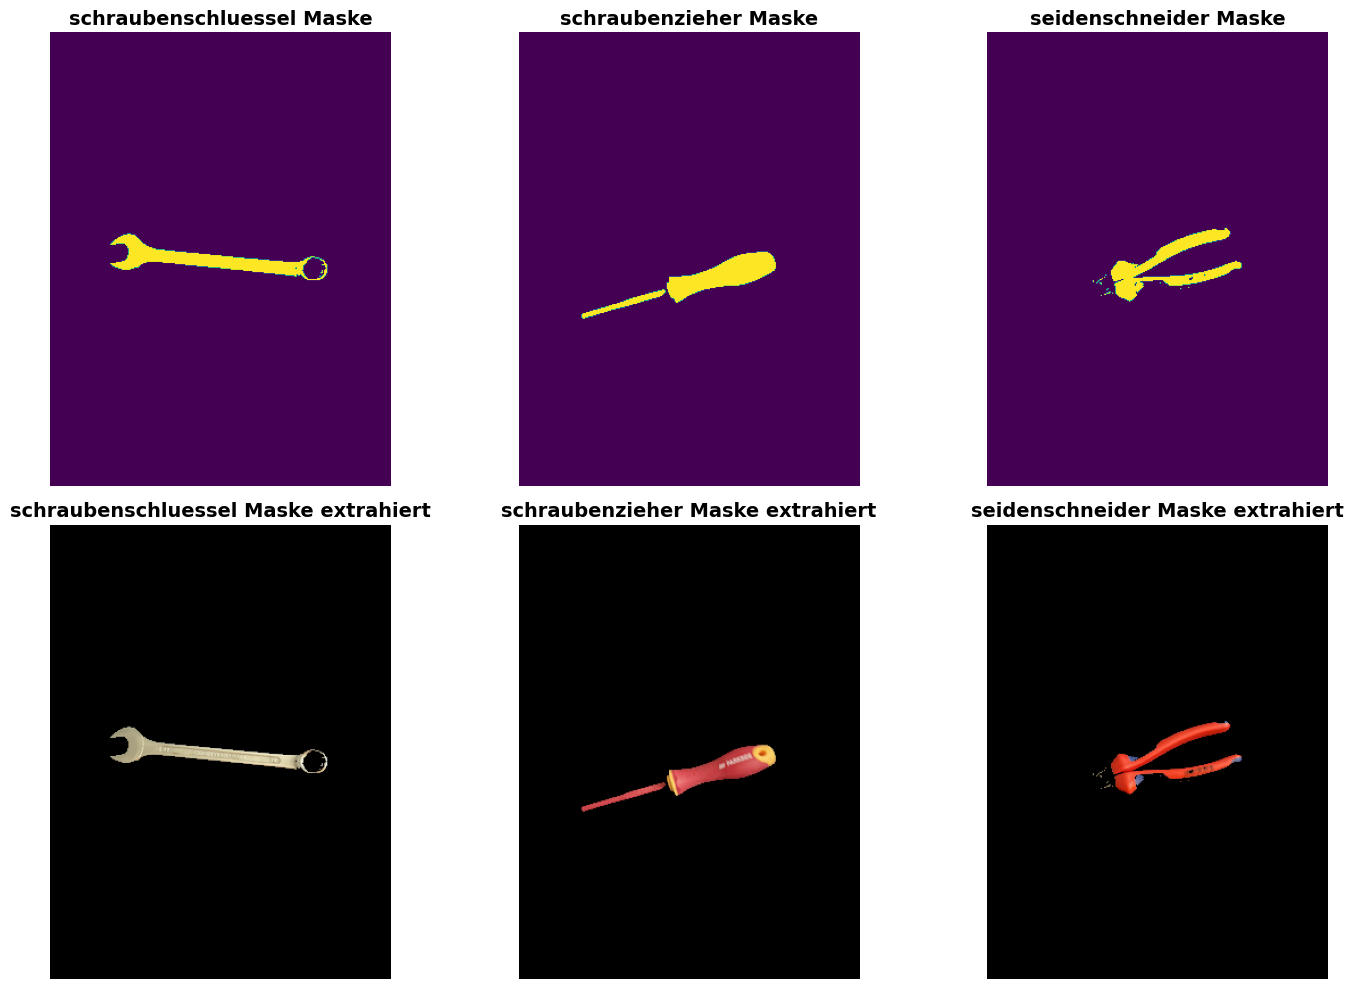

In [243]:
mask1, masked_image1 = create_mask_from_image(
    im1_resized,
    hue_threshold=None,
    saturation_threshold=None,
    value_threshold=vth
)
# Verwende die importierte Funktion aus dem Skript (aus Zelle 5)
mask2, masked_image2 = create_mask_from_image(
    im2_resized,
    hue_threshold=None,
    saturation_threshold=None,
    value_threshold=vth
)

mask3, masked_image3 = create_mask_from_image(
    im3_resized,
    hue_threshold=None,
    saturation_threshold=None,
    value_threshold=vth
)
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Erste Zeile: Masken
axes[0, 0].imshow(mask1)
axes[0, 0].set_title(klasse1 + " Maske", fontsize=14, fontweight='bold')
axes[0, 0].axis('off')

axes[0, 1].imshow(mask2)
axes[0, 1].set_title(klasse2 + " Maske", fontsize=14, fontweight='bold')
axes[0, 1].axis('off')

axes[0, 2].imshow(mask3)
axes[0, 2].set_title(klasse3 + " Maske", fontsize=14, fontweight='bold')
axes[0, 2].axis('off')

# Zweite Zeile: Maskierte Bilder
axes[1, 0].imshow(masked_image1)
axes[1, 0].set_title(klasse1 + " Maske extrahiert", fontsize=14, fontweight='bold')
axes[1, 0].axis('off')

axes[1, 1].imshow(masked_image2)
axes[1, 1].set_title(klasse2 + " Maske extrahiert", fontsize=14, fontweight='bold')
axes[1, 1].axis('off')

axes[1, 2].imshow(masked_image3)
axes[1, 2].set_title(klasse3 + " Maske extrahiert", fontsize=14, fontweight='bold')
axes[1, 2].axis('off')

plt.tight_layout()
plt.show()

## Schritt 4: Erosion und Dilatationsfilgergrössen bestimmen

Wenn Hintergrundregionen übrigbleiben, dann ergibt dies zusätzliche Trainingsbilder, welche nicht einer Klasse zugeordnet sind- und es kostet auch viel Rechenzeit. Kleine, isolierte Maskenpixel möchten wir daher als nächstes durch Erosion entfernen.

**Aufgabe 3:** Finden Sie Werte für es und ds, welche möglichst keine vereinzelte Hintergrundpixel in der Maske übrig lassen:

Ev. haben Sie auch Glück, und Sie sehen oben nur eine einzige zusammenhängende gelbe Struktur? Dann können Sie die Werte so lassen, wie sie sind!

`create_mask` ist nun einfach eine Routine, welche die obigen Schritte der Maskenbildung zusammenfasst. Sie sollte das gleiche Bild `morphed_mask` wie oben erstellen:

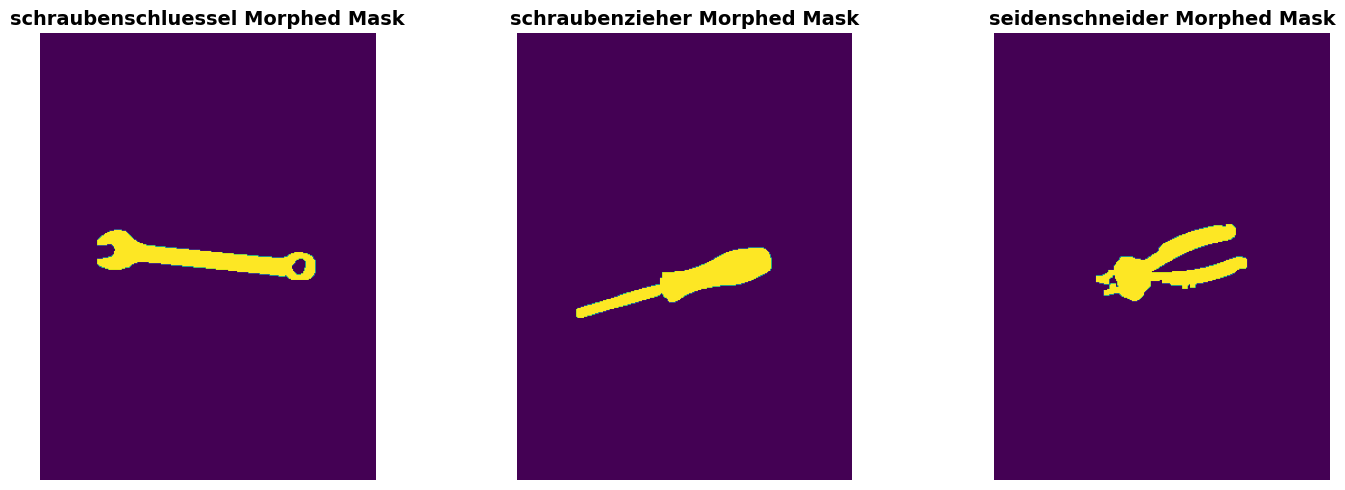

In [244]:
morphed_mask1 = create_mask(
    np.array(im1_resized), 
    hue_threshold=None,
    saturation_threshold=None,
    value_threshold=vth,
    erosion_size=es,
    dilation_size=ds
)
morphed_mask2 = create_mask(
    np.array(im2_resized), 
    hue_threshold=None,
    saturation_threshold=None,
    value_threshold=vth,
    erosion_size=es,
    dilation_size=ds
)
morphed_mask3 = create_mask(
    np.array(im3_resized), 
    hue_threshold=None,
    saturation_threshold=None,
    value_threshold=vth,
    erosion_size=es,
    dilation_size=ds
)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(morphed_mask1)
axes[0].set_title(klasse1 + " Morphed Mask", fontsize=14, fontweight='bold')
axes[0].axis('off')

axes[1].imshow(morphed_mask2)
axes[1].set_title(klasse2 + " Morphed Mask", fontsize=14, fontweight='bold')
axes[1].axis('off')

axes[2].imshow(morphed_mask3)
axes[2].set_title(klasse3 + " Morphed Mask", fontsize=14, fontweight='bold')
axes[2].axis('off')

plt.tight_layout()
plt.show()


Nun wird die Maske benutzt, um das Objekt (oder die Objekte) aus dem Bild auszuschneiden:
ich gebe den shape gleich mit aus. 

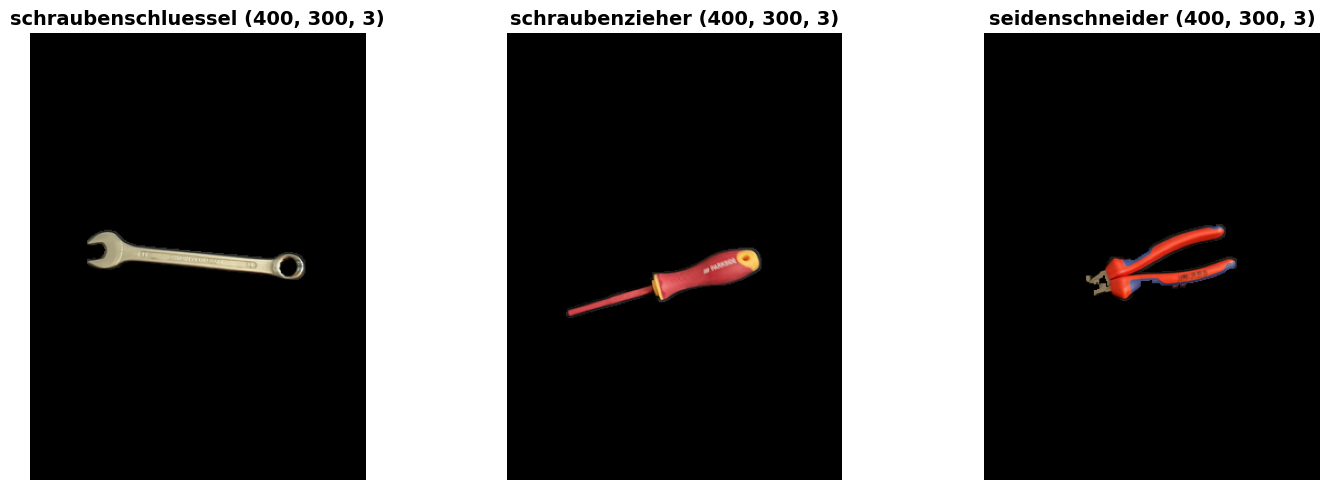

In [245]:
masked_image1 = create_masked_image(im1_resized, morphed_mask1)
masked_image2 = create_masked_image(im2_resized, morphed_mask2)
masked_image3 = create_masked_image(im3_resized, morphed_mask3)
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(masked_image1)
axes[0].set_title(klasse1 + " " + str(masked_image1.shape), fontsize=14, fontweight='bold')
axes[0].axis('off')

axes[1].imshow(masked_image2)
axes[1].set_title(klasse2 + " " + str(masked_image2.shape), fontsize=14, fontweight='bold')
axes[1].axis('off')

axes[2].imshow(masked_image3)
axes[2].set_title(klasse3 + " " + str(masked_image3.shape), fontsize=14, fontweight='bold')
axes[2].axis('off')

plt.tight_layout()
plt.show()

Hier sollte ein Bild zu sehen sein, welches einen komplett schwarzen Hintergrund hat, und nur die relevanten Objekte zeigt. Als nächstes hätten wir gerne von jedem Objekt ein separates Bild, so dass wir darauf unseren Bildklassifikator trainieren können.

## Schritt 5: Objekte ausschneiden
Wir haben den Hintergrund eliminiert. Damit ist es nun leichter, die Objekte voneinander zu trennen. Eine Funktion von [scikit-image](https://scikit-image.org/docs/stable/api/skimage.measure.html#skimage.measure.label) tut dies:

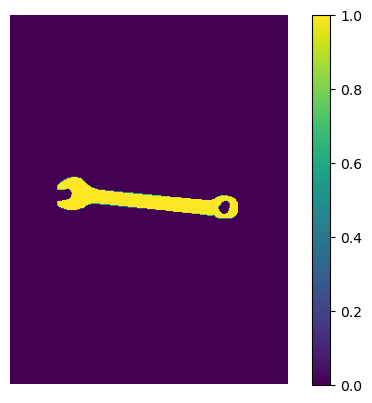

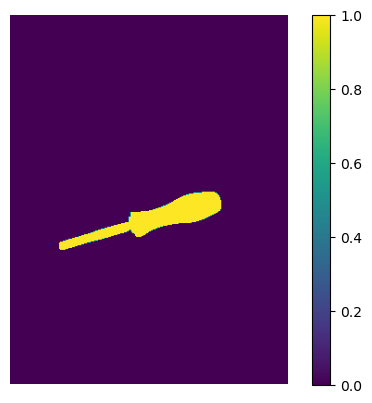

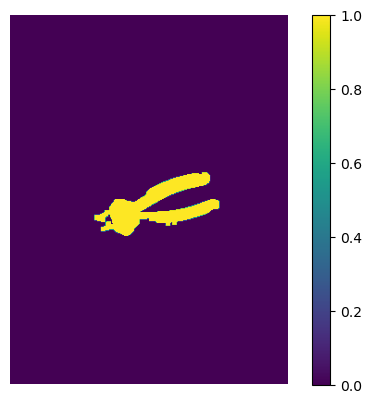

In [246]:
from skimage.measure import label
label_img1 = label(morphed_mask1)
label_img2 = label(morphed_mask2)
label_img3 = label(morphed_mask3)
show_image(label_img1, show_colorbar=True)
show_image(label_img2, show_colorbar=True)
show_image(label_img3, show_colorbar=True)


Falls das obige Bild wie eine Maske aussieht: Vermutlich liegt nur ein Bild vor- deren Pixel wird dann mit dem Wert "1" aufgefüllt. Wäre ein zweites Objekt vorhanden, würde dieses mit dem Wert "2" aufgefüllt und wäre in einer leicht anderen Farbe sichtbar. Aus diesem gelabelten Bild werden nun Teilbilder extrahiert, welche jeweils nur ein Objekt enthalten:

In [247]:
label_img1.shape,masked_image1.shape

((400, 300), (400, 300, 3))

In [248]:
regionlist1,regions1 = extract_regions(label_img1,masked_image1,fraction_of_rows_to_remove=fr)
print(klasse1 + " Regionen " + str(len(regionlist1)))
regionlist2,regions2 = extract_regions(label_img2,masked_image2,fraction_of_rows_to_remove=fr)
print(klasse2 + " Regionen " + str(len(regionlist2)))
regionlist3,regions3 = extract_regions(label_img3,masked_image3,fraction_of_rows_to_remove=fr)
print(klasse3 + " Regionen " + str(len(regionlist3)))

schraubenschluessel Regionen 1
schraubenzieher Regionen 1
seidenschneider Regionen 1


## Schritt 6: Kleine Objekte (Artefakte) ignorieren
Manchmal sind einige der gefundenen Regionen viel zu klein, um echte Objekte zu sein. Es gibt eine Option `--minimum-number-of-pixels` bzw. `-mpx`, welche Regionen unterdrückt, welche zu klein sind. Die Grösse der Regionen wird hier ausgegeben, um diesen Parameter gut einstellen zu können.

Region 0:   3496


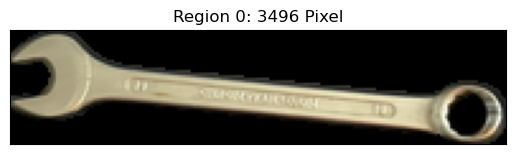

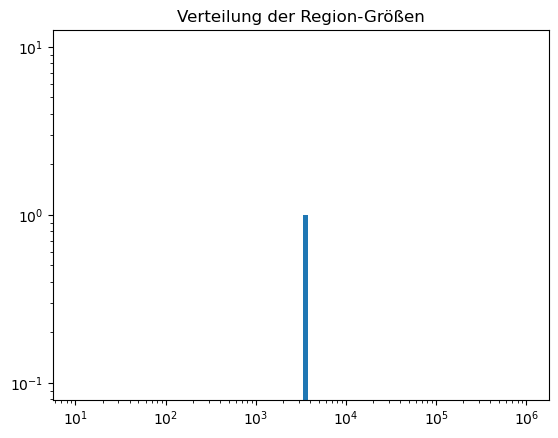

Region 0:   3325


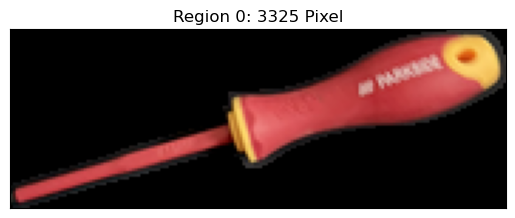

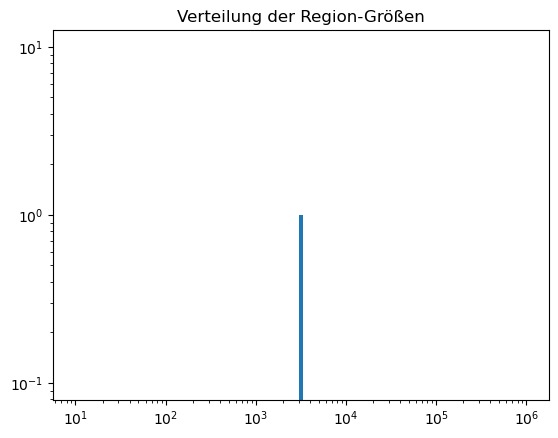

Region 0:   3617


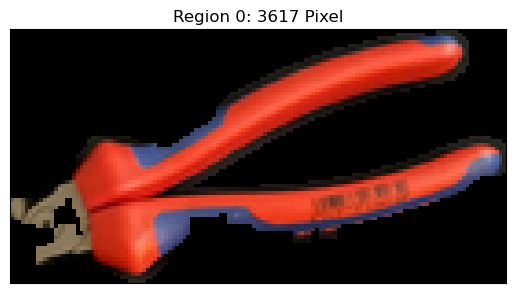

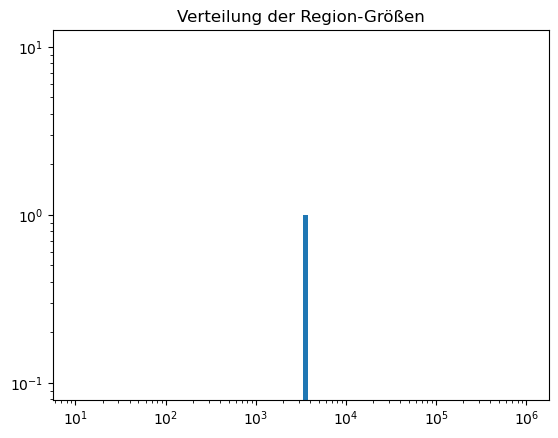

In [249]:

visualize_regions(regions1)
visualize_regions(regions2)
visualize_regions(regions3)

Schauen wir uns die extrahierten Regionen an - es sollten nicht zu viele sein.

**Aufgabe 4:** Bestimmen Sie einen geeigneten Wert von `mpx`, so dass nur relevante Regionen übrig bleiben. Tragen Sie den Wert in die Parameterliste ein.

Der `mpx`-Wert wird in der nächsten Zelle verwendet:

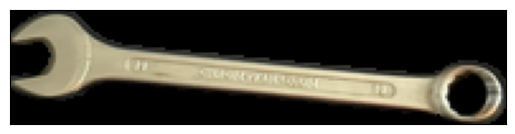

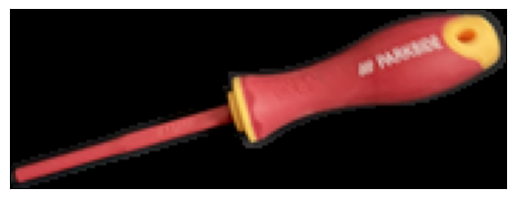

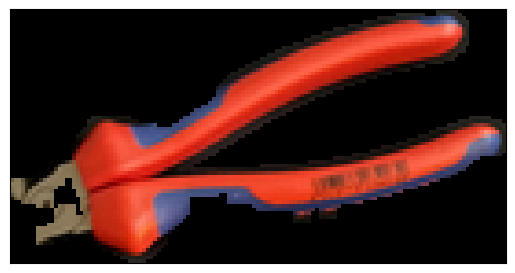

In [250]:
relevante_regionen1 = show_relevant_regions(regions1)
relevante_regionen2 = show_relevant_regions(regions2)
relevante_regionen3 = show_relevant_regions(regions3)

Sehen Sie hier Ihre extrahierten Objekte, und keine (oder nur wenige) Artefakte?  
Ja?  
Wirklich?  
**Cool!**  
Dann können wir nun versuchen, alle weiteren Daten zu verarbeiten. Das kann  in der Kommandozeile wie folgt erreicht werden:

In [253]:
Ausgabepfad = Path('/erstellt/object_extraction_output')
Ausgabepfad.mkdir(parents=True, exist_ok=True)
Ausgabepfad

WindowsPath('/erstellt/object_extraction_output')

In [252]:
from pathlib import Path

dataset_paths = {
    "schraubenzieher": Path("data/schraubenzieher"),
    "schraubenschluessel": Path("data/schraubenschluessel"),
    "seidenschneider": Path("data/seidenschneider"),
}

# Verwende einen lokalen Pfad statt des Kaggle-Pfads
output_path = Path("extracted")  # Relativer Pfad zum aktuellen Verzeichnis
output_path.mkdir(parents=True, exist_ok=True)
print(f"Extrahierte Bilder werden gespeichert in: {output_path.absolute()}")

for class_name, class_path in dataset_paths.items():
    print(f"\nExtrahiere Klasse: {class_name}")
    print("Pfad:", class_path)

    if not class_path.exists():
        print("  WARNUNG: Pfad existiert nicht – ueberspringe.")
        continue

    target_dir = output_path / class_name
    target_dir.mkdir(parents=True, exist_ok=True)

    # Suche nach verschiedenen Bildformaten (JPEG, jpg, jpeg, JPG, etc.)
    # Unterstützt sowohl Groß- als auch Kleinschreibung
    image_extensions = ["*.JPEG", "*.jpeg", "*.JPG", "*.jpg", "*.png", "*.PNG"]
    image_files = []
    for ext in image_extensions:
        image_files.extend(class_path.rglob(ext))
    
    # Entferne Duplikate (falls Dateien mit verschiedenen Groß-/Kleinschreibungen existieren)
    image_files = list(set(image_files))

    print(f"  {len(image_files)} Bilder gefunden")

    # Setze hue_threshold und saturation_threshold auf None, falls nicht definiert
    hue_thresh = hue_threshold if 'hue_threshold' in globals() else None
    sat_thresh = saturation_threshold if 'saturation_threshold' in globals() else None

    for file_path in image_files:
        process_file(
            file_path,
            fraction_of_rows_to_remove=fr,
            fraction_of_cols_to_remove=fc,
            hue_threshold=hue_thresh,
            saturation_threshold=None,
            value_threshold=vth,
            erosion_size=es,
            dilation_size=ds,
            min_num_pixels=mpx,
            preprocessing_resolution=pr,
            value_to_fill=fv,
            outputpath=str(target_dir),
        )

print("\nFertig! Extrahierte Bilder liegen unter:")
print(output_path)


INFO:object_extraction:Resize: Längere Seite wird auf 400px gesetzt. Neue Größe: (400, 300)


Extrahierte Bilder werden gespeichert in: d:\dev\git\privat\Studium\dsci-semesterarebeit\extracted

Extrahiere Klasse: schraubenzieher
Pfad: data\schraubenzieher
  117 Bilder gefunden


TypeError: create_mask() got an unexpected keyword argument 'fraction_of_rows_to_remove'

#### Train-Test-Split
An dieser Stelle lohnt es sich, kurz innezuhalten: Unsere grandiose Strategie ist es, aus Bildern Objekte zu extrahieren und auf diesen dann ein Modell zu trainieren. Aber wir können nicht alle Daten als Trainingsdaten verwenden, sonst haben wir nichts mehr, um die *Generalisierungsfähigkeit* unseres Modells zu messen!  
Die Realität ist, dass wir nur ungern später nochmals neue Daten aufnehmen wollen. Die Liste in `df` oben ist alles, was uns zur Verfügung steht. Es macht daher Sinn, bereits jetzt einen Teil dieser Daten zurückzulegen und zu *schwören* diese Daten nicht für das Training zu benutzen. Wir brauchen ca. 20% *frische* Daten, an denen wir die Verallgemeinerungsfähigkeit unseres Modells überprüfen können.  
[Scikit-Learn](https://scikit-learn.org) bietet uns [hier](https://scikit-learn.org/stable/auto_examples/model_selection/plot_cv_indices.html#sphx-glr-auto-examples-model-selection-plot-cv-indices-py) verschiedene Strategien an, wie wir aus unseren Trainingsdaten einen Testdatensatz absondern können. Wir könnten einfach [zufällig splitten](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html#sklearn.model_selection.ShuffleSplit). Das ist naiv. Lieber eine [k-fache Kreuzvalidierung](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html#sklearn.model_selection.KFold). Aber was, wenn zufälligerweise eine Klasse nur im Testdatensatz auftaucht, und gar nicht im Trainingsdatensatz?! Also [stratifizieren](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html#sklearn.model_selection.StratifiedKFold) wir. Ok- und was ist, wenn wir überprüfen wollen, dass wir in Bezug auf eine bestimmte Untergruppierung (z.B. nach Geschlecht, Ethnie,...) gut von einer Gruppe auf eine andere verallgemeinern können müssen? Dann darf eine [Gruppe nur in einem Fold vorkommen](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedGroupKFold.html#sklearn.model_selection.StratifiedGroupKFold). Sie sehen- richtig zu splitten kann herausfordernd sein!  
Hier jedenfalls möchten wir zumindest stratifizieren. Wir nehmen mal [StratifiedKFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html#sklearn.model_selection.StratifiedKFold), um unsere Daten zu splitten.

In [ ]:
import pandas as pd
from pathlib import Path

# Verwende den gleichen output_path wie in Cell 61
# Falls Cell 61 nicht ausgeführt wurde, verwende einen lokalen Pfad
try:
    # Versuche den output_path aus Cell 61 zu verwenden
    base = output_path
except NameError:
    # Falls output_path nicht definiert ist, verwende einen lokalen Pfad
    base = Path("extracted")  # Relativer Pfad zum aktuellen Verzeichnis
    if not base.exists():
        # Versuche auch einen absoluten Pfad
        base = Path(os.getcwd()) / "extracted"

print(f"Suche extrahierte Bilder in: {base}")

if not base.exists():
    print(f"WARNUNG: Der Pfad {base} existiert nicht!")
    print("Bitte führen Sie zuerst Cell 61 aus, um die Bilder zu extrahieren.")
    print("Oder passen Sie den Pfad manuell an.")
    df = pd.DataFrame(columns=["Dateiname", "Basisname", "Klassenlabel"])
else:
    rows = []
    
    for klasse in ["schraubenzieher", "schraubenschluessel", "seidenschneider"]:
        kpfad = base / klasse
        if kpfad.exists():
            for fn in kpfad.glob("*.*"):
                # Überspringe Verzeichnisse
                if fn.is_file():
                    rows.append({
                        "Dateiname": str(fn),           # voller Pfad
                        "Basisname": fn.name,           # z.B. "img_001.jpg"
                        "Klassenlabel": klasse          # z.B. "schraubenzieher"
                    })
        else:
            print(f"WARNUNG: Pfad {kpfad} existiert nicht für Klasse {klasse}")
    
    df = pd.DataFrame(rows)
    print(f"Gefunden: {len(df)} Dateien")
    if len(df) > 0:
        print(df.head())
        print(f"\nAnzahl Zeilen: {len(df)}")
    else:
        print("Keine Dateien gefunden! Bitte führen Sie zuerst Cell 61 aus.")

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df["KlassenID"] = le.fit_transform(df["Klassenlabel"])
df.head()

In [ ]:
from sklearn.model_selection import train_test_split

Xtrain, Xtest, ytrain, ytest = train_test_split(
    df[['Dateiname','Basisname']],
    df['Klassenlabel'],
    test_size=0.2,
    train_size=0.8,
    stratify=df['Klassenlabel'],
    random_state=42
)

# Output wie im Original-Notebook
print(Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape)

print("Trainingsdaten")
display(ytrain.value_counts())

print("\nTestdaten")
display(ytest.value_counts())

print('\nKlassenverhältnis:')
display((ytest.value_counts() / ytrain.value_counts()))


Die Ausgaben oben zeigen die Anzahl Beispiele pro Klasse in den Training- und Testdaten sowie das Verhältnis pro Klasse. Das Verhältnis sollte für alle Klasse etwa gleich gross sein- dies nennt sich *stratifiziertes Training-Test-Splitten*.

In [ ]:
display(Xtrain.head())
ytrain

#### Shutil - High-level File Operations
Wir kopieren nun die Daten in Unterordner von `pfad_zu_lcl_colab/2_Baumstruktur/`. Die Unterordner sollen die Klassennamen (Farben) sein.

In [ ]:
import shutil
from pathlib import Path

# Prüfe, ob die DataFrames existieren und Daten enthalten
if 'Xtrain' not in globals() or 'Xtest' not in globals() or 'ytrain' not in globals() or 'ytest' not in globals():
    print("FEHLER: Xtrain, Xtest, ytrain oder ytest sind nicht definiert!")
    print("Bitte führen Sie zuerst die Zellen aus, die den Train-Test-Split durchführen.")
    raise NameError("Xtrain, Xtest, ytrain oder ytest fehlen")

if len(Xtrain) == 0 or len(Xtest) == 0:
    print("WARNUNG: Xtrain oder Xtest sind leer!")
    print(f"Xtrain hat {len(Xtrain)} Zeilen")
    print(f"Xtest hat {len(Xtest)} Zeilen")
    print("Bitte prüfen Sie, ob df korrekt erstellt wurde und Daten enthält.")

# Basis-Ausgabepfad
baum_train = Ausgabepfad / "2_Baumstruktur_train"
baum_test  = Ausgabepfad / "2_Baumstruktur_test"

# Bestehende Ordner löschen (optional, falls mehrfach ausgeführt)
if baum_train.exists():
    shutil.rmtree(baum_train)
if baum_test.exists():
    shutil.rmtree(baum_test)

# TRAIN-Daten kopieren
train_copied = 0
train_errors = 0
for basisname, voller_Dateiname, label in zip(Xtrain.Basisname, Xtrain.Dateiname, ytrain):
    src = Path(voller_Dateiname)
    if not src.exists():
        print(f"  WARNUNG: Quell-Datei existiert nicht: {src}")
        train_errors += 1
        continue
    
    dst = baum_train / label
    dst.mkdir(parents=True, exist_ok=True)
    try:
        shutil.copy(src, dst / basisname)
        train_copied += 1
    except Exception as e:
        print(f"  FEHLER beim Kopieren von {src.name}: {e}")
        train_errors += 1

print(f"\nTrainingsdateien: {train_copied} erfolgreich kopiert, {train_errors} Fehler")
print(f"Ziel: {baum_train.absolute()}")

# TEST-Daten kopieren
test_copied = 0
test_errors = 0
for basisname, voller_Dateiname, label in zip(Xtest.Basisname, Xtest.Dateiname, ytest):
    src = Path(voller_Dateiname)
    if not src.exists():
        print(f"  WARNUNG: Quell-Datei existiert nicht: {src}")
        test_errors += 1
        continue
    
    dst = baum_test / label
    dst.mkdir(parents=True, exist_ok=True)
    try:
        shutil.copy(src, dst / basisname)
        test_copied += 1
    except Exception as e:
        print(f"  FEHLER beim Kopieren von {src.name}: {e}")
        test_errors += 1

print(f"\nTestdateien: {test_copied} erfolgreich kopiert, {test_errors} Fehler")
print(f"Ziel: {baum_test.absolute()}")

print(f"\n{'='*60}")
print(f"Zusammenfassung:")
print(f"  Train: {train_copied}/{len(Xtrain)} Dateien kopiert")
print(f"  Test:  {test_copied}/{len(Xtest)} Dateien kopiert")
print(f"{'='*60}")


Überprüfen wir die Struktur! Die Klassenverzeichnisse sind hier:

In [ ]:
print("Training-Baumstruktur:")
if baum_train.exists():
    for item in sorted(baum_train.iterdir()):
        if item.is_dir():
            print(f"  📁 {item.name}/")
        else:
            print(f"  📄 {item.name}")
else:
    print(f"  WARNUNG: Verzeichnis existiert nicht: {baum_train}")

print("\nTest-Baumstruktur:")
if baum_test.exists():
    for item in sorted(baum_test.iterdir()):
        if item.is_dir():
            print(f"  📁 {item.name}/")
        else:
            print(f"  📄 {item.name}")
else:
    print(f"  WARNUNG: Verzeichnis existiert nicht: {baum_test}")

Und darunter befinden sich die zur Klasse zugehörigen Bilder:

In [ ]:
print("Training-Baumstruktur (Inhalt der Klassenordner):")
if baum_train.exists():
    for class_dir in sorted(baum_train.iterdir()):
        if class_dir.is_dir():
            files = list(class_dir.glob("*"))
            print(f"\n  📁 {class_dir.name}/ ({len(files)} Dateien)")
            for f in sorted(files)[:10]:  # Zeige max. 10 Dateien pro Klasse
                print(f"      📄 {f.name}")
            if len(files) > 10:
                print(f"      ... und {len(files) - 10} weitere Dateien")
else:
    print(f"  WARNUNG: Verzeichnis existiert nicht: {baum_train}")

print("\nTest-Baumstruktur (Inhalt der Klassenordner):")
if baum_test.exists():
    for class_dir in sorted(baum_test.iterdir()):
        if class_dir.is_dir():
            files = list(class_dir.glob("*"))
            print(f"\n  📁 {class_dir.name}/ ({len(files)} Dateien)")
            for f in sorted(files)[:10]:  # Zeige max. 10 Dateien pro Klasse
                print(f"      📄 {f.name}")
            if len(files) > 10:
                print(f"      ... und {len(files) - 10} weitere Dateien")
else:
    print(f"  WARNUNG: Verzeichnis existiert nicht: {baum_test}")

Nun wollen wir diese zwei Baumstrukturen herunterladen:

In [ ]:
from IPython.display import FileLink
import zipfile
import shutil
from pathlib import Path

# ============================================================================
# WICHTIG: Leere den extracted Ordner vor der ZIP-Erstellung
# ============================================================================
# Dies stellt sicher, dass nur Dateien aus dem aktuellen data Ordner im ZIP sind
extracted_path = Path('extracted')
if extracted_path.exists():
    print("=" * 70)
    print("LEERE EXTRACTED ORDNER")
    print("=" * 70)
    
    # Zähle Dateien vor dem Löschen
    total_files = 0
    for klasse_dir in extracted_path.iterdir():
        if klasse_dir.is_dir():
            count = len(list(klasse_dir.glob('*.*')))
            total_files += count
            print(f"  {klasse_dir.name}: {count} Dateien")
    
    print(f"\n  Gesamt: {total_files} Dateien werden gelöscht")
    
    # Lösche den gesamten extracted Ordner
    shutil.rmtree(extracted_path)
    print(f"✓ Ordner '{extracted_path}' wurde geleert")
    
    # Erstelle den Ordner neu (leer)
    extracted_path.mkdir(exist_ok=True)
    print(f"✓ Ordner '{extracted_path}' wurde neu erstellt (leer)")
    print("=" * 70)
    print()
else:
    print(f"⚠️ Ordner '{extracted_path}' existiert nicht - wird erstellt")
    extracted_path.mkdir(exist_ok=True)

def create_zip_from_directory(source_dir, zip_filename):
    """Erstellt eine ZIP-Datei aus einem Verzeichnis"""
    if not source_dir.exists():
        print(f"WARNUNG: Quellverzeichnis existiert nicht: {source_dir}")
        return None
    
    with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
        # Durchlaufe alle Dateien im Verzeichnis rekursiv
        for file_path in source_dir.rglob('*'):
            if file_path.is_file():
                # Erstelle relativen Pfad für die ZIP-Datei
                arcname = file_path.relative_to(source_dir.parent)
                zipf.write(file_path, arcname)
    
    print(f"✓ ZIP-Datei erstellt: {zip_filename} ({Path(zip_filename).stat().st_size / 1024 / 1024:.2f} MB)")
    return zip_filename

# ZIP Training
zip_train = "training_Baumstruktur.zip"
if baum_train.exists():
    create_zip_from_directory(baum_train, zip_train)
    FileLink(zip_train)
else:
    print(f"FEHLER: {baum_train} existiert nicht!")

# ZIP Test
zip_test = "testing_Baumstruktur.zip"
if baum_test.exists():
    create_zip_from_directory(baum_test, zip_test)
    FileLink(zip_test)
else:
    print(f"FEHLER: {baum_test} existiert nicht!")

Die folgenden Ausgaben geben einen Link an. Bitte klicken Sie ihn an und speichern Sie die .zip-Datei lokal ab. Sie sollten sie anschliessend extrahieren und überprüfen, ob die Baumstruktur stimmt.

In [ ]:
FileLink(r'training_Baumstruktur.zip')

In [ ]:
FileLink(r'testing_Baumstruktur.zip')

**Gratulation!!!** Damit sind wir bereit für das Training eines neuronalen Netzes. Weiter geht's im Notebook `2_training/Training.ipynb.